## Логистическая регрессия

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (5,5)
plt.rcParams['lines.markersize'] = 6

Реализуйте обучение логистической регрессии с $L^1$ и $L^2$ регуляризацией с помощью метода Stochastic Gradient Descent (SGD)

#### Замечания
* В SGD градиент расчитывается по одному случайному объекту
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в выборке (тем или иным способом)

# Реализация модели

Final theta [29.25038343 -6.0919473   4.35227533]


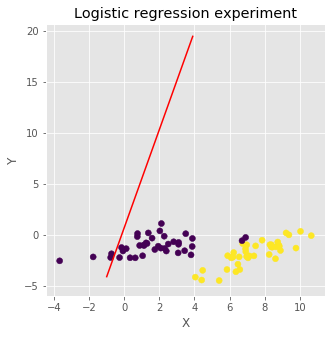

In [882]:
from sklearn.metrics import zero_one_loss
from sklearn.base import BaseEstimator, ClassifierMixin
import math
import random

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """

    regularisation_algorithms = ['l1', 'l2', None]
    
    def __init__(self, C=1, alpha=0.01, max_epoch=10, penalty=None):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch

        if penalty in self.regularisation_algorithms:
            self.penalty = penalty
            self.reg_function = self.__get_regularisation_function(penalty)
        else:
            raise AttributeError('Unknown regularisation algorithm {0}'.format(penalty))

    def __get_regularisation_function(self, penalty):
        if penalty == 'l1':
            return self.__l1_regularisation
        if penalty == 'l2':
            return self.__l2_regularisation
        else:
            return self.__none_regularisation
        return 1

    def __l1_regularisation(self, y, margin):
        return self.C * abs(y - margin)

    def __l2_regularisation(self, y, margin):
        return self.C * (y - margin) ** 2

    def __none_regularisation(self, _y, _margin):
        return 0.0

    def fit(self, X, y):
        '''
        Обучение модели
        '''
        (length, dims) = X.shape
        self.dimensions = dims + 1
        self.collection_len = length
        self.collection = self.__add_c_coefficient(X, length)
        self.function_values = y
        self.theta = self.__get_random_theta(self.dimensions)

        self.__gradient_descent()
        
        return self

    def __add_c_coefficient(self, x, length):
        # Уравнение прямой a * x + b * y + c = 0
        # У нас в 
        return np.hstack([x, np.ones((length, 1))])

    def __gradient_descent(self):
        theta = self.theta
        for _epoch in range(self.max_epoch):
            p = np.random.permutation(len(self.collection))
            for index in p:
                xi = self.collection[index]
                yi = self.function_values[index]
                margin = self.__margin(theta, xi)
                sigma = self.__sigmoid(margin)
                # Формулу взял отсюда http://www.machinelearning.ru/wiki/images/6/68/voron-ML-Lin.pdf
                # За исключением релуляризации self.reg_function её просто подставил. Скорее всего это неправильно.
                # Однако я не нашёл ни в лекции ни в интернете как использовать одноверменно регуляризацию и стохастический градиентный спуск.
                # Подскажите как это сделать одновременно. Если возможно - формулой)
                # При увеличении количества эпох или элементов, сильно возрастают параметры Theta.
                # И неудивительно, ведь в формуле нет ни одного отрицательного члена.
                # При этом прямая разделяющаяся, остаётся похожей а Theta возрастает пропорционально:
                # http://joxi.ru/p27P98eUKWX1YA
                # http://joxi.ru/GrqpXM6C4kWPDA
                gradient = self.alpha * sigma * xi * yi + self.reg_function(yi, sigma)
                # Возможно я неправильно применяю
                gradient = gradient.reshape((self.dimensions, 1))
                theta = np.add(theta, gradient)

        self.theta = theta.reshape(1, self.dimensions)[0]
        return True

    # Функция использовалась во время дебага убрал т.к. во время обхода, Theta принимает очень уж большие значения http://joxi.ru/D2PLYjRCqk95N2
    def print_theta(self, theta):
        x_naive = np.arange(-1, 4, 0.1)
        [a, b, c] = theta.reshape(1, self.dimensions)[0]
        y_naive = -1 * (a / b) * x_naive - (c / b)
        plt.plot(x_naive, y_naive, c='g', label='way to optimal decision')
        return

    def __get_random_theta(self, dim):
        return np.array([random.random() for _ in range(dim)]).reshape(dim, 1)

    def __margin(self, theta, x):
        x = x.reshape((1, self.dimensions))
        margin = x.dot(theta)[0][0]
        return margin

    def __sigmoid(self, z):
        sigmoid = 1 / (1 + np.exp(-z))
        return sigmoid
    
    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
    
        return self
        
    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        margin = self.__margin(self.theta, X)
        y_hat = self.__sigmoid(margin)
        return round(y_hat)
    
    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''

        
        return y_hat_proba

classifier = MySGDClassifier(C=1, alpha=0.005, max_epoch=20)

np.random.seed(1)

size = 40

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(size, 2) + np.array([7, 5]), C1)
gauss2 = np.dot(np.random.randn(size, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
Classes = np.r_[np.ones(size), np.zeros(size)]
classifier.fit(X, Classes)

x_naive = np.arange(-1, 4, 0.1)
print('Final theta {0}'.format(classifier.theta))
# Уравнение прямой a * x + b * y + c = 0
[a, b, c] = classifier.theta
# Соответственно Y выражается как y = -1 * (a / b) * x - (c / b)
y_naive = -1 * (a / b) * x_naive - (c / b)

plt.plot(x_naive, y_naive, c='red', label='descision boundary')

plt.scatter(X[:, 0], X[:, 1], c=Classes)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Logistic regression experiment')
plt.show()



## Проверка на синтетических данных (2 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

In [5]:
model = MySGDClassifier()
model.fit(X, y)

MySGDClassifier(C=1, alpha=0.01, max_epoch=10, penalty=None)

In [886]:
round(0.51)

1

## Анализ сходимости

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/эпохи (выбрать одно) для разных `alpha`.

In [9]:
print(np.ones((10, 1)))

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
